# Simulation of open quantum systems

Schroedinger's equation describes closed quantum systems in which all dynamics
are described by unitary propagators and hence reversible. To simulate the loss
of information caused by relaxation effects, we can describe the system as open
quantum system with a master equation in Lindblad form:

\begin{equation}
\frac{d\rho}{dt}=-i[\rho, H] + \sum_k \left( L_k \rho L_k^\dagger
- \frac{1}{2} L_k^\dagger L_k \rho
- \frac{1}{2} \rho L_k^\dagger L_k \right)
\end{equation}

Lets consider the example of a rabi driven qubit again, but this time we take
relaxations into the ground state into account, which attribute to the so
called $T_1$-time or depolarization time.

So the Hamiltonian is given by:

\begin{equation}
H = \frac{\hbar A}{2} \text{cos} (\delta ) \sigma_x
+ \frac{\hbar A}{2} \text{sin} (\delta ) \sigma_y
\end{equation}

And the Lindblad operator, which describes the dissipative effects:

\begin{equation}
L = \sqrt{\gamma} \cdot \sigma^-
\end{equation}

where $\gamma = 1 / T_1$ is the depolarization rate and the descending operator

\begin{equation}
\sigma^- = \frac{1}{2} (\sigma_x - i \sigma_y)  =
\begin{pmatrix}
0 & 0 \\
1 & 0
\end{pmatrix}.
\end{equation}

In [1]:
import numpy as np
from qsim.matrix import DenseOperator


sigma_x = DenseOperator(np.asarray([[0, 1], [1, 0]]))
sigma_y = DenseOperator(np.asarray([[0, -1j], [1j, 0]]))
sigma_z = DenseOperator(np.asarray([[1, 0], [0, -1]]))
sigma_minus =DenseOperator(np.asarray([[0, 0], [1, 0]]))
zero_matrix = DenseOperator(np.asarray([[0, 0], [0, 0]]))

h_ctrl = [.5 * sigma_x, .5 * sigma_y]
h_drift = [zero_matrix]

The master equation can be linearized with the Kronecker product, for which
holds:

\begin{align}
AXB = C \Leftarrow \Rightarrow (B^T \otimes A) \vec{X} = \vec{C}
\end{align}

The linearized form of the master equation is then:

\begin{align}
\frac{d}{dt} \vec{\rho} = (-i \mathcal{H} + \mathcal{G}) \vec{\rho}
\end{align}

with
\begin{align}
\mathcal{H} = I \otimes H - H \otimes I
\end{align}

and the dissipation operator

\begin{align}
\mathcal{G} = \sum_k (L^\ast_k \otimes L_k)
- \frac{1}{2} I \otimes (L_k^\dagger L_k)
- \frac{1}{2} ( L_k^T L_k^\ast ) \otimes I.
\end{align}

The master equation can be implemented in two different ways. Either we
 define the Lindblad operators and their corresponding prefactors, or
we construct the dissipation operator.

Lets discuss the former option and assume that the relaxation rate is
proportional to the driving amplitude:

\begin{align}
L = \sqrt{\gamma} \sigma^- = \sqrt{\gamma_0 \vert u \vert} \sigma^-
\end{align}

In [2]:
lindblad_operators = [sigma_minus, ]
gamma_0 = .001

def prefactor_function(control_amplitudes):
    return gamma_0 * np.expand_dims(
        np.sum(np.abs(control_amplitudes), axis=1), axis=1)


def prefactor_function_derivative(control_amplitudes):
    return np.expand_dims(gamma_0 * np.sign(control_amplitudes), axis=2)

The prefactor function now returns the depolarization rate $\gamma$, which is
the squared amplitude of the lindblad operator. The simulation package assumes
that the Lindblad operators can be given as constant operator $L_k$, which is
multiplied with a prefactor $c_k$ to calculate the dissipation operator as:

\begin{align}
\mathcal{G} = \sum_k c_k (L_k^\ast \otimes L_k
- \frac{1}{2} I \otimes (L_k^\dagger L_k)
- \frac{1}{2} ( L_k^T L_k^\ast ) \otimes I)
\end{align}

The derivatives of the prefactor function must be implemented as well if the
derivative of the cost function shall be calculated.

Now we can instantiate the solver and cost function.

In [3]:
from qsim.solver_algorithms import LindbladSolver
from qsim.cost_functions import OperationInfidelity

total_time = 1
n_time_steps = 5
time_steps = (total_time / n_time_steps) * np.ones((n_time_steps, ))

solver = LindbladSolver(
    h_drift=h_drift * n_time_steps,
    h_ctrl=h_ctrl,
    initial_state=DenseOperator(np.eye(4)),
    tau=time_steps,
    lindblad_operators=lindblad_operators,
    prefactor_function=prefactor_function,
    prefactor_derivative_function=prefactor_function_derivative
)

x_half = sigma_x.exp(np.pi * .25j)

entanglement_infid = OperationInfidelity(
    solver=solver,
    target=x_half,
    super_operator_formalism=True
)


Please note that we have to set the option super_operator_formalism in the
cost function to True. Next we optimize the control amplitudes.

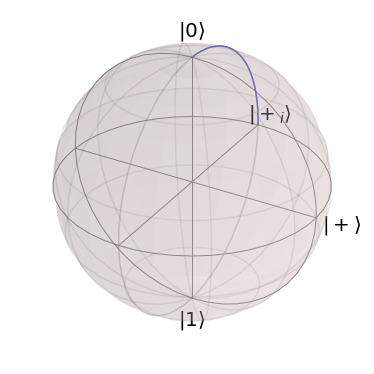

In [24]:
from qsim.simulator import Simulator
from qsim.optimize import LeastSquaresOptimizer
simulator = Simulator(
    solvers=[solver],
    cost_fktns=[entanglement_infid]
)

termination_conditions = {
    "min_gradient_norm": 1e-15,
    "min_cost_gain": 1e-15,
    "max_wall_time": 120.0,
    "max_cost_func_calls": 1e6,
    "max_iterations": 10000,
    "min_amplitude_change": 1e-8
}

upper_bounds = 5 * 2 * np.pi * np.ones((len(h_ctrl) * n_time_steps, ))
lower_bounds = -1 * upper_bounds

optimizer = LeastSquaresOptimizer(
    system_simulator=simulator,
    termination_cond=termination_conditions,
    save_intermediary_steps=True,
    bounds=[lower_bounds, upper_bounds]
)

np.random.seed(0)
initial_pulse = np.pi * 2 * (np.random.rand(n_time_steps, len(h_ctrl)) - 1)

result = optimizer.run_optimization(initial_control_amplitudes=initial_pulse)
solver.set_optimization_parameters(result.final_parameters)
solver.plot_bloch_sphere()

To verify that the implemented derivatives of the prefactor function is
correct, we can compare our derivatives with finite differences. The
convenience function compare_numeric_to_analytic_gradient calculates the
absolute and relative difference to the finite difference gradient.

In [27]:
simulator.compare_numeric_to_analytic_gradient(initial_pulse)


(1.633248503059409e-08, 9.851677024373317e-08)